In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF

seed = 1

In [24]:
raw_documents = fetch_20newsgroups(subset='all', random_state=seed)['data']
raw_documents = [x.lower() for x in raw_documents]

In [26]:
custom_stop_words = []
with open( "stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower() )

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
terms = vectorizer.get_feature_names()

In [28]:
kmin, kmax = 10, 30

nmf_topic_models = []
for k in range(kmin,kmax+1):
    model = NMF( init="nndsvd", n_components=k, random_state=seed ) 
    W = model.fit_transform( A )
    H = model.components_    
    nmf_topic_models.append( (k,W,H) )

In [29]:
lsa_topic_models = []
for k in range(kmin,kmax+1):
    model = TruncatedSVD(n_components=k, random_state=seed ) 
    W = model.fit_transform( A )
    H = model.components_    
    lsa_topic_models.append( (k,W,H) )

In [30]:
lda_topic_models = []
for k in range(kmin,kmax+1):
    model = LatentDirichletAllocation(n_components=k, max_iter=5,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=seed)
    W = model.fit_transform( A )
    H = model.components_    
    lda_topic_models.append( (k,W,H) )

In [31]:
import re
import gensim


class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens
            

docgen = TokenGenerator( raw_documents, custom_stop_words )
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

In [32]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

K=10: Coherence=0.2512
K=11: Coherence=0.2460
K=12: Coherence=0.2759
K=13: Coherence=0.2595
K=14: Coherence=0.2718
K=15: Coherence=0.2856
K=16: Coherence=0.2567
K=17: Coherence=0.2684
K=18: Coherence=0.2714
K=19: Coherence=0.2762
K=20: Coherence=0.2649
K=21: Coherence=0.2770
K=22: Coherence=0.2824
K=23: Coherence=0.2706
K=24: Coherence=0.2756
K=25: Coherence=0.2956
K=26: Coherence=0.2872
K=27: Coherence=0.2823
K=28: Coherence=0.2842
K=29: Coherence=0.2917
K=30: Coherence=0.2763


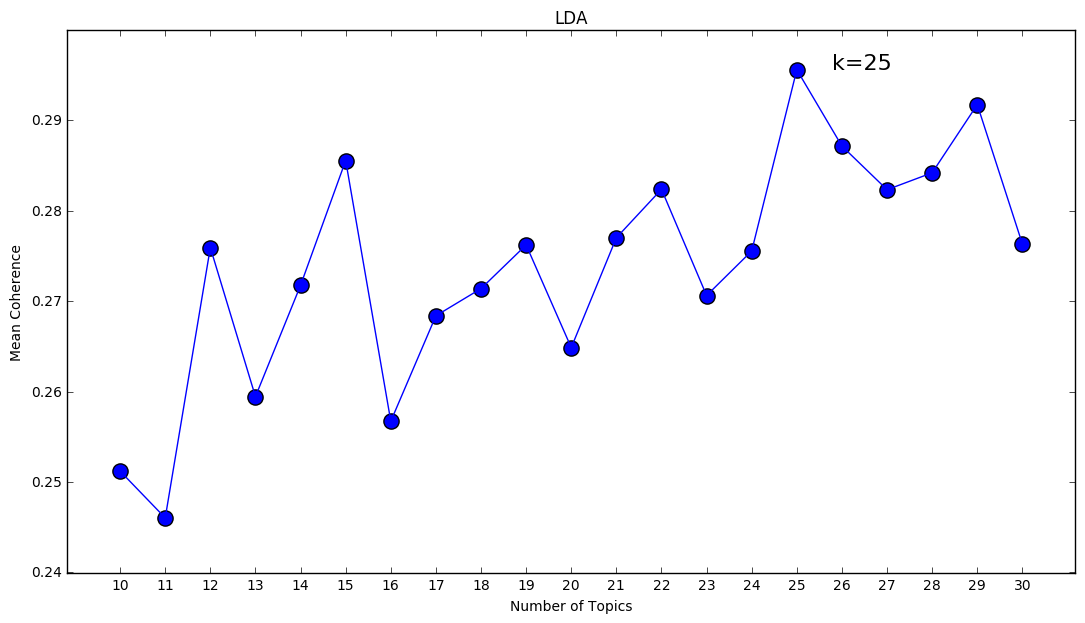

K=10: Coherence=0.2381
K=11: Coherence=0.2530
K=12: Coherence=0.2633
K=13: Coherence=0.2576
K=14: Coherence=0.2440
K=15: Coherence=0.2573
K=16: Coherence=0.2549
K=17: Coherence=0.2564
K=18: Coherence=0.2540
K=19: Coherence=0.2601
K=20: Coherence=0.2559
K=21: Coherence=0.2525
K=22: Coherence=0.2553
K=23: Coherence=0.2530
K=24: Coherence=0.2557
K=25: Coherence=0.2546
K=26: Coherence=0.2561
K=27: Coherence=0.2524
K=28: Coherence=0.2572
K=29: Coherence=0.2536
K=30: Coherence=0.2527


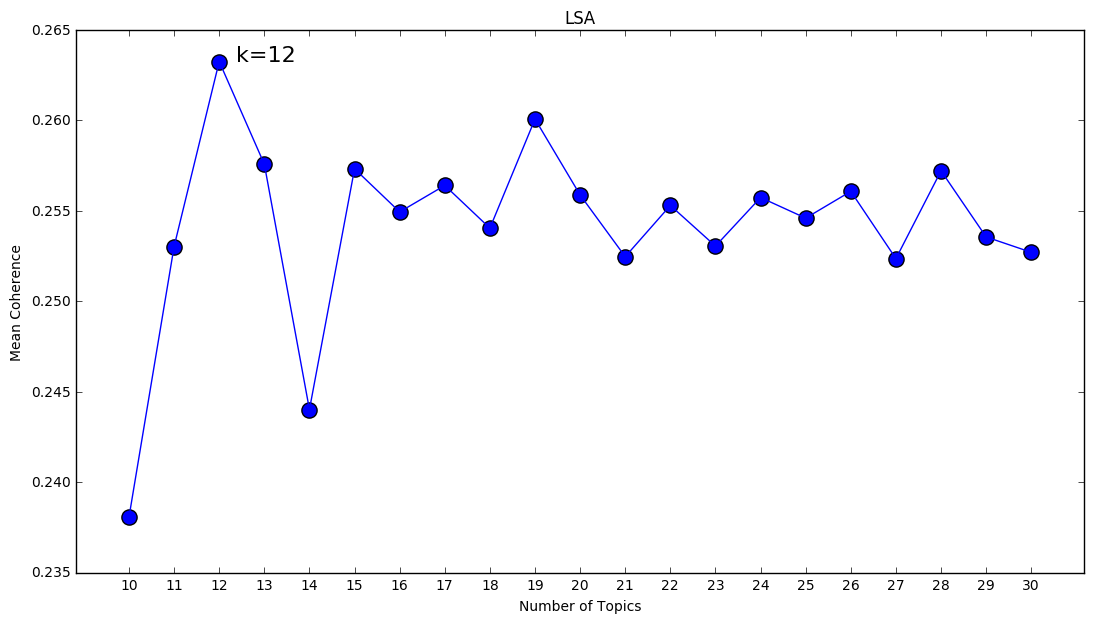

K=10: Coherence=0.3004
K=11: Coherence=0.3126
K=12: Coherence=0.3249
K=13: Coherence=0.3325
K=14: Coherence=0.3293
K=15: Coherence=0.3359
K=16: Coherence=0.3343
K=17: Coherence=0.3381
K=18: Coherence=0.3413
K=19: Coherence=0.3439
K=20: Coherence=0.3539
K=21: Coherence=0.3463
K=22: Coherence=0.3532
K=23: Coherence=0.3497
K=24: Coherence=0.3498
K=25: Coherence=0.3613
K=26: Coherence=0.3583
K=27: Coherence=0.3679
K=28: Coherence=0.3575
K=29: Coherence=0.3737
K=30: Coherence=0.3728


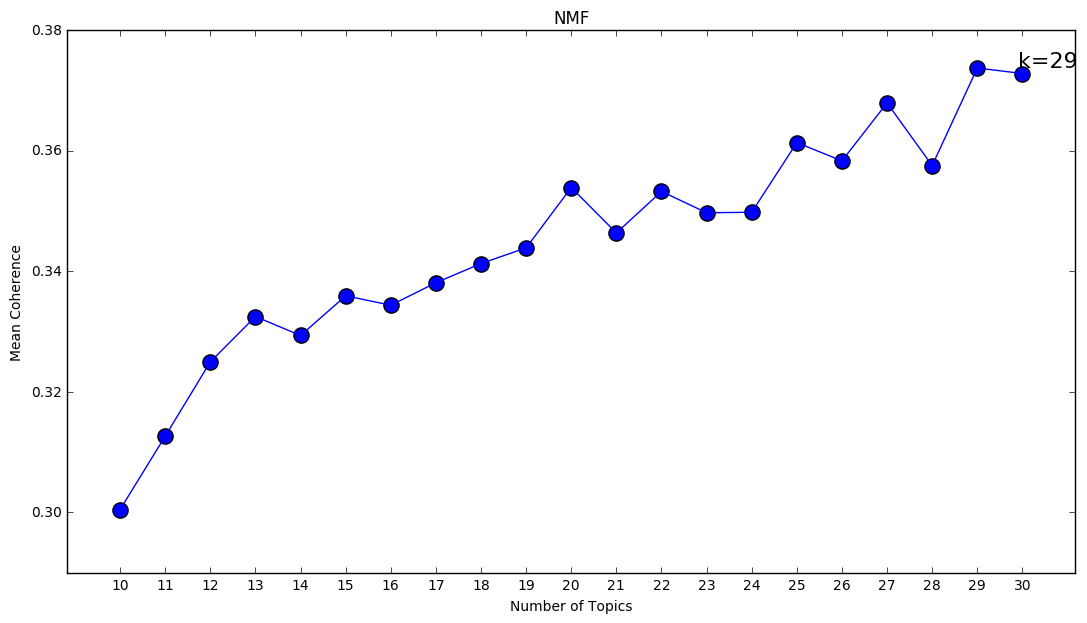

In [40]:
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


topic_models = {'NMF':nmf_topic_models, 'LSA':lsa_topic_models, 'LDA':lda_topic_models}
for model, tm in topic_models.items():
    k_values = []
    coherences = []
    for (k,W,H) in tm:
        # Get all of the topic descriptors - the term_rankings, based on top 20 terms
        term_rankings = []
        for topic_index in range(k):
            term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
        # Now calculate the coherence based on our Word2vec model
        k_values.append( k )
        coherences.append( calculate_coherence( w2v_model, term_rankings ) )
        print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

    fig = plt.figure(figsize=(13,7))
    # create the line plot
    ax = plt.plot( k_values, coherences )
    plt.xticks(k_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Mean Coherence")
    plt.title(model)
    # add the points
    plt.scatter( k_values, coherences, s=120)
    # find and annotate the maximum point on the plot
    ymax = max(coherences)
    xpos = coherences.index(ymax)
    best_k = k_values[xpos]
    plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
    # show the plot
    plt.show()

In [42]:
# get the model that we generated earlier.
W = nmf_topic_models[29-kmin][1]
H = nmf_topic_models[29-kmin][2]

for topic_index in range(29):
    descriptor = get_descriptor( terms, H, topic_index, 20 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: com, netcom, sun, hp, writes, article, organization, att, subject, lines, 408, corp, reply, posting, distribution, east, nntp, mark, host, mot
Topic 02: god, jesus, bible, christian, christ, believe, christians, faith, sin, church, people, life, christianity, love, hell, heaven, religion, think, rutgers, lord
Topic 03: edu, university, cc, cs, posting, nntp, host, organization, subject, lines, article, washington, columbia, writes, mit, berkeley, utexas, distribution, colorado, thanks
Topic 04: windows, dos, file, files, window, program, os, run, microsoft, nt, mouse, problem, running, help, version, manager, pc, ftp, system, software
Topic 05: key, clipper, chip, encryption, keys, escrow, government, algorithm, security, des, nsa, crypto, phone, system, secure, secret, wiretap, public, sternlight, privacy
Topic 06: game, team, games, hockey, players, baseball, espn, season, play, win, fans, nhl, player, go, league, teams, think, boston, detroit, wings
Topic 07: scsi, drive, 

In [57]:
from sklearn.neighbors import NearestNeighbors

class NewsRecommender:
    """
    обучить систему на корпусе текстов  с помощью тематической модели и метрики, выбранных в результате исследования
    """
    def train(self, texts):
        self.texts = texts
        lower_texts = [x.lower() for x in self.texts]

        with open( "stopwords.txt", "r" ) as f:
            custom_stop_words = [line.strip().lower() for line in f.readlines()]
        self.vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
        A = self.vectorizer.fit_transform(lower_texts)
        
        self.model = NMF( init="nndsvd", n_components=29, random_state=seed )
        W = self.model.fit_transform(A)
        
        self.neigh = NearestNeighbors()
        self.neigh.fit(W)
        
    """
    выдать k самых пожих новостей для заданного заголовка по функции расстояния, выбранной в результате исследования
    обратите внимание, что text_sample может содержать слова не из обучающего корпуса
    """
    def recommend(self, text_sample, k):
        text_sample = text_sample.lower()
        A = self.vectorizer.transform([text_sample])
        W = self.model.transform(A)
        closest = [self.texts[i] for i in self.neigh.kneighbors(W, n_neighbors=k, return_distance=False)[0]]
        return closest

In [54]:
print(raw_documents[6])

from: martijn@cs.vu.nl (lemmens ml)
subject: workgroups for windows
organization: fac. wiskunde & informatica, vu, amsterdam
lines: 22

hello,

i want a little network for 3 users. all users want to run windows.
the most important things i want for the network are: file-sharing,
mail utility, two printers on one of the computers and a fax/modem
card on one of the computers. we all want to use each others harddisk.

my idea was to buy three computers (one 486dx and two 386dx). all
three have a 40mb local harddisk, the 486 also has a very large
harddisk. all three also have a network card. the 486 is connected to
the printers and contains the fax/modem card. and last but not least:
workgroups for windows.

my questions:
- is this possible?
- what exactly are the possibilities and advantages of workgroups
  for windows?
- will all the computers be fast enough? behind all three, someone
  is working.

thanks,
martijn



In [60]:
recommender = NewsRecommender()
recommender.train(raw_documents)

In [61]:
closest3 = recommender.recommend(raw_documents[6], 3)
for c in closest3:
    print(c,'-'*30,sep='\n')

from: martijn@cs.vu.nl (lemmens ml)
subject: workgroups for windows
organization: fac. wiskunde & informatica, vu, amsterdam
lines: 22

hello,

i want a little network for 3 users. all users want to run windows.
the most important things i want for the network are: file-sharing,
mail utility, two printers on one of the computers and a fax/modem
card on one of the computers. we all want to use each others harddisk.

my idea was to buy three computers (one 486dx and two 386dx). all
three have a 40mb local harddisk, the 486 also has a very large
harddisk. all three also have a network card. the 486 is connected to
the printers and contains the fax/modem card. and last but not least:
workgroups for windows.

my questions:
- is this possible?
- what exactly are the possibilities and advantages of workgroups
  for windows?
- will all the computers be fast enough? behind all three, someone
  is working.

thanks,
martijn

------------------------------
from: dsou@btma57.nohost.nodomain
subject

In [62]:
with open('bbc.txt','r',encoding='utf-8') as f:
    text = f.read()
closest3 = recommender.recommend(text, 3)
for c in closest3:
    print(c,'-'*30,sep='\n')

from: adam@endor.uucp (adam shostack)
subject: re: ten questions about israel
organization: aiken computation lab, harvard university
lines: 64

in article <1483500349@igc.apc.org> cpr@igc.apc.org (center for policy research) writes:
ten questions about arab countries
----------------------------------

i would be thankful if any of you who live in arab countries could
help to provide accurate answers to the following specific questions.
these are indeed provocative questions but they are asked time and
again by people around me.

1.      is it true that many arab countries don't recognize
israeli nationality ?  that people with israeli stamps on their
passports can't enter arabic countries?

2.      is it true that arabic countries such as jordan and syria
have undefined borders and that arab governments from 1948 until today
have refused to state where the ultimate borders of their states
should be?

3.      is it true that arab countires refused to sign the chemical
weapon conventio